In [12]:
from collections.abc import Iterable
import os

from adjustText import adjust_text
import colorsys
from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import latex
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import pickle
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import pywt
import scipy.io as sio
import scipy
from scipy.stats import multivariate_normal, spearmanr, kendalltau, pearsonr
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import skimage.io as skio
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from tifffile import TiffFile
import tifffile

from networkx import kamada_kawai_layout

from atlas import loadmat, NPAtlas, NWBAtlas
from process_file import get_nwb_neurons, get_dataset_neurons, get_dataset_online, combine_datasets, get_pairings, get_color_discrim, get_neur_nums
from stats import get_summary_stats, analyze_pairs, get_accuracy
from visualization import plot_num_heatmap, plot_std_heatmap, plot_summary_stats, plot_color_discrim, plot_accuracies, plot_visualizations_atlas, plot_visualizations_data, plot_atlas2d_super
from utils import covar_to_coord, convert_coordinates, maha_dist, run_linear_assignment

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
#from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries

In [81]:
#Optional import if you want to open figures in a separate window, add %matplotlib qt to top of any code box if you want figures to open in a separate window 
import PyQt6.QtCore
os.environ["QT_API"] = "pyqt6"

# Figure 4: Summary statistics of datasets

Figure 4 contains summary statistics of included datasets as well as analyses of the correspondence between neuron positional variability and ganglion membership, synaptic connectivity, and cell lineage.

In [2]:
atlas = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_match_full_nosplit.pkl') # Load atlas
atlas_df = atlas.get_df()
atlas_neurons = np.asarray(atlas_df['ID'])
atlas.df = atlas.df.drop(atlas.df[atlas.df['ID']=='IL1V'].index)

In [98]:
'''
Can either load datasets using get_dataset_neurons with path to a folder of NWB files or using get_dataset_online to stream in data from an online dandiset.
Note that streaming from online will take much longer to load here but bypasses the need to have any files stored on your local hard drive.
'''

data_path = 'insert path to folder containing NWB files to load'
#dataset = get_dataset_neurons(data_path, atlas_neurons)

#EY_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/final_nwb/EY', atlas_neurons) #dandi_id = 000541
#SK1_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/final_nwb/SK1', atlas_neurons) #dandi_id = 000565
#NP_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/final_nwb/NP_og', atlas_neurons) #dandi_id = 000715
#SK2_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/final_nwb/SK2', atlas_neurons) #dandi_id = 000472
#HL_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/final_nwb/HL', atlas_neurons) #dandi_id = 000714

EY_dataset = get_dataset_online('000541', atlas_neurons) #dandi_id = 000541
SK1_dataset = get_dataset_online('000565', atlas_neurons) #dandi_id = 000565
NP_dataset = get_dataset_online('000715', atlas_neurons) #dandi_id = 000715
SK2_dataset = get_dataset_online('000472', atlas_neurons) #dandi_id = 000472
HL_dataset = get_dataset_online('000714', atlas_neurons) #dandi_id = 000714
KK_dataset = get_dataset_online('000692', atlas_neurons) #dandi_id = 000692
SF_dataset = get_dataset_online('000776', atlas_neurons) #dandi_id = 000776

20190924_02
20190924_01
20190925_04
20190924_03
20190925_01
20190928_03
20190928_05
20190928_01
20190928_08
20190928_11
20190929_02
20190928_13
20190929_05
20190929_03
20190928_07
20190929_07
20191104_10
20191030_03
20191104_08
20190929_06
20191030_07
20221106-21-00-09
20221215-20-02-49
20221106-21-47-31
20221028-18-48-00
20221106-21-23-19
20230322-21-41-10
20230322-22-43-03
20230412-20-15-17
20230506-12-56-00
20230506-14-24-57
20230322-18-57-04
20230510-13-25-46
20230510-15-49-47
20230904-14-30-52
20230904-15-09-05
20230904-15-59-40
20230909-16-48-09
20230510-12-53-34
20230322-20-16-50
20230506-15-01-45
20230506-15-33-51
56_YAaDV
38_YAaDV
11_YAaLR
55_YAaDV
20_YAaLR
62_YAaLR
70_YAaLR
7_YAaLR
64_YAaDV
76_YAaDV
2022-02-11-w03-NP1
2021-12-03-w00-NP1
2022-02-12-w00-NP1
2022-02-12-w01-NP1
2022-01-22-w04-NP1
2022-02-22-w04-NP1
2022-04-01-w00-NP1
2022-03-05-w00-NP1
2022-04-26-w01-NP1
2022-04-26-w00-NP1
5
4
2
1
7
6
8
3
9
20230918-9-54-0
20230928-14-27-0
20230928-11-14-0
20230918-13-21-0
202309

In [8]:
'''
Pass datasets generated by get_dataset_neurons to combine datasetes. Can pass any number of datasets as 
list elements. This will preserve which file each neuron comes from but not which original folder
'''

tot_dataset = combine_datasets([EY_dataset, SK1_dataset, NP_dataset, SK2_dataset, HL_dataset, KK_dataset, SF_dataset])
pair_tot = get_pairings(tot_dataset)

### Summary for each neuron: percent labeled and pairwise positional variability

In [5]:
seg = []
ID = []
labels = ['EY', 'SK1', 'SK2', 'NP', 'HL', 'KK', 'SF']

for i, dataset in enumerate([EY_dataset, SK1_dataset, SK2_dataset, NP_dataset, HL_dataset, KK_dataset, SF_dataset]):
    num_seg = np.zeros(len(dataset.keys()))
    num_ID = np.zeros(len(dataset.keys()))
    for j, key in enumerate(dataset.keys()):
        value = dataset[key]
        segmented = len(value)
        IDd = value[value['ID']!='']
        num_ID[j] = len(IDd)
        num_seg[j] = segmented

    seg.append(num_seg)
    ID.append(num_ID)

    print(labels[i])
    print('Number of included worms: ' + str(len(num_seg)))
    print('Average segmented: ' + str(np.mean(num_seg)))
    print('Average IDd: ' + str(np.mean(num_ID)))
    print('Min segmented: ' + str(np.min(num_seg)))
    print('Max segmented: ' + str(np.max(num_seg)))
    print('Min IDd: ' + str(np.min(num_ID)))
    print('Max IDd: ' + str(np.max(num_ID)))

EY
Number of included worms: 21
Average segmented: 177.42857142857142
Average IDd: 175.04761904761904
Min segmented: 166.0
Max segmented: 188.0
Min IDd: 164.0
Max IDd: 184.0
SK1
Number of included worms: 21
Average segmented: 111.0952380952381
Average IDd: 48.19047619047619
Min segmented: 78.0
Max segmented: 139.0
Min IDd: 30.0
Max IDd: 82.0
SK2
Number of included worms: 10
Average segmented: 173.2
Average IDd: 49.3
Min segmented: 166.0
Max segmented: 180.0
Min IDd: 38.0
Max IDd: 63.0
NP
Number of included worms: 10
Average segmented: 193.1
Average IDd: 190.3
Min segmented: 189.0
Max segmented: 196.0
Min IDd: 186.0
Max IDd: 193.0
HL
Number of included worms: 9
Average segmented: 118.77777777777777
Average IDd: 64.33333333333333
Min segmented: 113.0
Max segmented: 125.0
Min IDd: 58.0
Max IDd: 69.0
KK
Number of included worms: 9
Average segmented: 154.22222222222223
Average IDd: 154.22222222222223
Min segmented: 149.0
Max segmented: 163.0
Min IDd: 149.0
Max IDd: 163.0
SF
Number of includ

In [6]:
def get_neur_nums(tot_dataset, atlas):

    neur_IDs = atlas.df['ID']

    num_datasets = len(tot_dataset.keys())
    neurons = {k:0 for k in neur_IDs}

    for dataset in tot_dataset.keys():
        blobs = tot_dataset[dataset]

        for i, row in blobs.iterrows():
            ID = row['ID']
            if ID == '':
                continue

            if not ID in neurons:
                neurons[ID] = 1

            else:
                neurons[ID] += 1

    return neurons, num_datasets

def plot_neur_nums(neurons, num_datasets, atlas):

    fig, axs = plt.subplots()

    neur_df = atlas.df[['ID', 'ganglion']]

    dict_df = pd.DataFrame(list(neurons.items()), columns = ['ID', 'num'])
    dict_df['frac'] = dict_df['num']/num_datasets
 
    merged = pd.merge(neur_df, dict_df, on='ID') #this will preserve the order of neurons from neur_df which is sorted by ganglion and then distance along x axis

    sns.set(style='white')
    sns.barplot(ax=axs,y='ID', x='frac', hue='ganglion', data=merged, orient='h')

    axs.set_ylabel('')
    axs.set_xlabel('')

    axs.spines[['right', 'bottom', 'left', 'top']].set_visible(False)
    axs.tick_params(labelleft=False, left=False)
    plt.legend([],[], frameon=False)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    bar_width = 1

    for patch in axs.patches:
        current_width = patch.get_height()
        diff = current_width - bar_width
        # Change the bar width
        patch.set_height(bar_width)

        # Recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

    axs.invert_xaxis()
    # Show the plot
    axs.legend(title='ganglion', loc='lower left')

    plt.show()


In [27]:
def plot_std_heatmap(num_heatmap, std_heatmap, df_ganglia):

    plt.rcParams.update({'font.size': 20})

    ganglia_indices = {}

    for ganglion in df_ganglia['ganglion'].unique():
        # Find the indices where the category starts and ends
        start_index = df_ganglia.index[df_ganglia['ganglion'] == ganglion][0]
        end_index = df_ganglia.index[df_ganglia['ganglion'] == ganglion][-1]
        
        # Store the start and end indices in the dictionary
        ganglia_indices[ganglion] = (start_index, end_index)

    # Create the figure and ax objects
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_facecolor('black')

    mask = np.where(num_heatmap < 0.4, True, False)

    # Create the heatmap using the ax object
    sns.heatmap(std_heatmap, cmap='Reds', cbar_kws = dict(use_gridspec=False,location="bottom"))

    highlight_boxes = [((ganglia_indices[gang][0], ganglia_indices[gang][0]), (ganglia_indices[gang][1], ganglia_indices[gang][1]), gang) for gang in df_ganglia['ganglion'].unique()]

    # Overlay boxes
    for (x1, y1), (x2, y2), label in highlight_boxes:
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='black', lw=3))
        if x1<len(df_ganglia)/2:
            plt.text(x2+2, (y1 + y2) / 2, label, color='black', ha='left', va='center')
        else:
            plt.text(x1-2, (y1 + y2) / 2, label, color='black', ha='right', va='center')

    ax.set_title('Pairwise positional variability', fontsize=20)
    plt.tick_params(which='both', bottom=False, left=False,labelbottom=False, labelleft=False)  # Hide tick labels
    plt.show()

In [10]:
def plot_sum_heatmap(heatmap,df):

    plt.rcParams.update({'font.size': 20})

    fig, axs = plt.subplots()
    
    avg_std = np.sum(heatmap,axis=0)/heatmap.shape[0]

    new_df = df.copy()

    new_df['std'] = avg_std

    sns.barplot(data=new_df, y='ID', x='std', hue='ganglion', ax=axs, orient='h', dodge=False)

    plt.legend([],[], frameon=False)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.yticks([])

    plt.title('Mean positional variability')
    plt.xlabel('')
    plt.ylabel('')

    axs.spines[['right', 'bottom', 'left', 'top']].set_visible(False)

    plt.show()

    return np.asarray(new_df['std'])

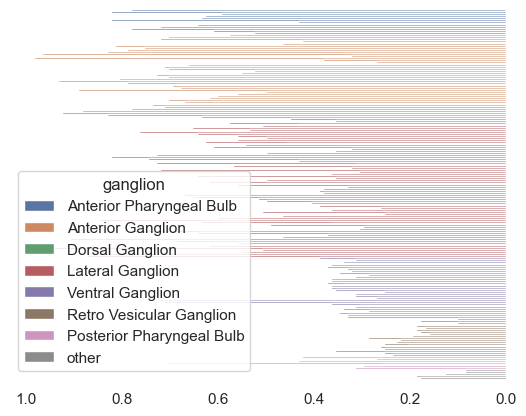

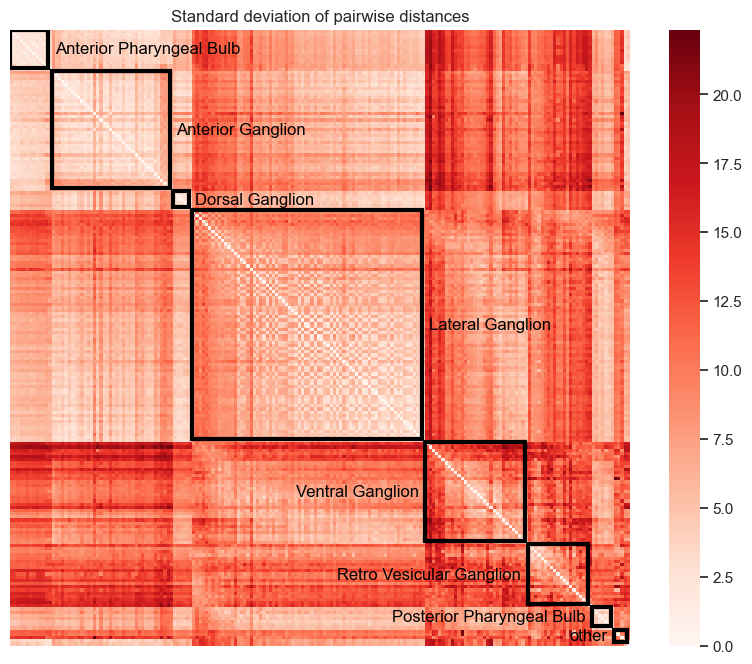

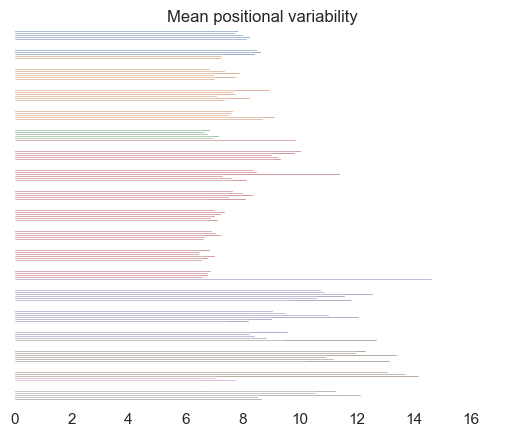

In [11]:
neurons, num = get_neur_nums(tot_dataset, atlas)
plot_neur_nums(neurons, num, atlas)

num_pair, num_heatmap, total_std_heatmap = analyze_pairs(pair_tot, atlas.df, len(tot_dataset.keys()))
plot_std_heatmap(num_heatmap, total_std_heatmap, atlas.df)

stds = plot_sum_heatmap(total_std_heatmap, atlas.df)

### Analysis of ganglion membership

In [78]:
def get_ganglia_variance(atlas_df, pairs, num_neighbors):

    ganglia = {}
    visited_pair = []
    X = np.asarray(atlas_df[['X','Y','Z']])
    neighbors = NearestNeighbors(n_neighbors=num_neighbors, algorithm='auto')

    neighbors.fit(X)

    neighbor_dists, neighbor_index = neighbors.kneighbors(X=X, return_distance = True)

    for i, row in atlas_df.iterrows():
        neighbors = neighbor_index[i,1:]
        neighb_dists = neighbor_dists[i, 1:]
        ID = row['ID']
        ganglion = row['ganglion']
        for j, neighbor in enumerate(neighbors):
            n_ID = atlas_df.loc[neighbor, 'ID']
            n_gang = atlas_df.loc[neighbor, 'ganglion']
            if ganglion < n_gang:
                gang_pair = ganglion + '-' + n_gang
            else:
                gang_pair = n_gang + '-' + ganglion

            if ID == n_ID:
                break
            elif ID < n_ID:
                pair = ID + '-' + n_ID
            else:
                pair = n_ID + '-' + ID

            if pair in pairs.keys() and pair not in visited_pair:
                pair_dists = pairs[pair]
                pair_std = np.std(pair_dists)

                if not gang_pair in ganglia.keys():
                    ganglia[gang_pair] = [pair_std]
                else:
                    ganglia[gang_pair].append(pair_std)

                visited_pair.append(pair)

    return ganglia

def plot_ganglion_variance(pair_tot, ganglia):
    plt.rcParams.update({'font.size': 80})
    fig, axs = plt.subplots()
    sns.set(style='white')
    marker_size = 12

    abbrevs = {'Anterior Pharyngeal Bulb':'Anterior pharynx', 'Anterior Ganglion':'Anterior', 'Dorsal Ganglion':'Dorsal', 'Lateral Ganglion':'Lateral', 'Ventral Ganglion':'Ventral', 'Retro Vesicular Ganglion':'Retro-vesicular', 'Posterior Pharyngeal Bulb':'Posterior pharynx','other':'Oth'}
    order = ['AntBulb-AntBulb', 'Ant-Ant', 'Dors-Dors', 'Lat-Lat', 'Vent-Vent', 'RVG-RVG', 'PostBulb-PostBulb', 'Ant-AntBulb', 'Ant-Vent','Dors-Lat', 'Lat-Vent','Lat-RVG','Lat-PostBulb', 'RVG-Vent', 'PostBulb-Vent']
    gangorder = ['Anterior pharynx', 'Anterior', 'Dorsal', 'Lateral', 'Ventral', 'Retro-vesicular']

    data = {'abbrev':[], 'name':[], 'ganglion1':[], 'ganglion2':[], 'std':[], 'intra':[], 'nameintra':[]}

    for key, values in ganglia.items():
        ganglion1, ganglion2 = key.split('-')

        if len(values)<5:
            continue

        for value in values:
            if ganglion1 =='other' or ganglion2 =='other':
                continue
            data['abbrev'].append(abbrevs[ganglion1] + '-' +abbrevs[ganglion2])
            data['ganglion1'].append(ganglion1)
            data['ganglion2'].append(ganglion2)
            data['name'].append(abbrevs[ganglion1])
            data['std'].append(value)
            data['intra'].append(ganglion1 == ganglion2)
            data['nameintra'].append(abbrevs[ganglion1]+str(ganglion1==ganglion2))

            if not ganglion1 == ganglion2:
                data['abbrev'].append(abbrevs[ganglion2] + '-' +abbrevs[ganglion1])
                data['ganglion1'].append(ganglion1)
                data['ganglion2'].append(ganglion2)
                data['name'].append(abbrevs[ganglion2])
                data['std'].append(value)
                data['intra'].append(ganglion1 == ganglion2)
                data['nameintra'].append(abbrevs[ganglion2]+str(ganglion1==ganglion2))

    df = pd.DataFrame(data)

    palette = sns.color_palette() #Choose color palette and then get similar low saturation palette by converting to HSV calues and then converting back to RGB
    HSV_palette = [colorsys.rgb_to_hsv(color[0],color[1],color[2]) for color in palette]
    low_palette = [tuple(colorsys.hsv_to_rgb(HSV[0], HSV[1]*0.3, HSV[2])) for HSV in HSV_palette]
    name_colors = {'Anterior pharynxTrue':palette[0], 'AnteriorTrue':palette[1], 'DorsalTrue':palette[2], 'LateralTrue':palette[3], 'VentralTrue':palette[4], 'Retro-vesicularTrue':palette[5], 'Posterior pharynxTrue':palette[6], 'OthTrue':palette[7], 'Anterior pharynxFalse':low_palette[0], 'AnteriorFalse':low_palette[1], 'DorsalFalse':low_palette[2], 'LateralFalse':low_palette[3], 'VentralFalse':low_palette[4], 'Retro-vesicularFalse':low_palette[5], 'Posterior pharynxFalse':low_palette[6], 'OthFalse':low_palette[7]}
    color_order = ['Anterior pharynxFalse','Anterior pharynxTrue', 'AnteriorFalse', 'AnteriorTrue', 'DorsalFalse', 'DorsalTrue', 'LateralFalse', 'LateralTrue', 'VentralFalse', 'VentralTrue', 'Retro-vesicularFalse', 'Retro-vesicularTrue', ]

    g1 = sns.barplot(ax=axs, data= df, order = color_order, x='nameintra', y='std', hue='nameintra', alpha=0.8, hue_order = color_order, errorbar=None, dodge=False, palette=name_colors)
    g2 = sns.stripplot(ax=axs, data=df, order=color_order, x='nameintra',y='std', hue='nameintra', hue_order = color_order, legend=False, dodge=False, palette=name_colors)

    axs.set_ylabel('Pairwise positional variability (um)')
    x= np.arange(len(color_order))
    axs.set_xlabel(None)
    axs.set_xticks([])
    
    for name in df['name'].unique():
        df_name = df[df['name']==name]
        intra = np.asarray(df_name[df_name['intra']==True]['std'])
        inter = np.asarray(df_name[df_name['intra']==False]['std'])
        stats = scipy.stats.ttest_ind(intra, inter, equal_var=False)
        pval = stats.pvalue
        tval = stats.statistic
        deg_free = stats.df
        SEM = np.std(np.append(inter, intra))/np.sqrt((len(intra)+len(inter)))
        lower_effect = (np.mean(intra) - np.mean(inter)) -2*SEM
        upper_effect = (np.mean(intra) - np.mean(inter)) +2*SEM
        print('For ganglion '+name +'' +': t-statistic - '+ str(tval) +', pvalue - ' + str(pval)+ ', df - '+str(deg_free))
        print('95 percent effect size range: ' + str(lower_effect) + '-' +str(upper_effect))
        print('Pairs in same ganglion: ' +str(len(intra)))
        print('Pairs in different ganglia: '+ str(len(inter)))

    plt.show()

For ganglion Anterior: t-statistic - -1.412711508488264, pvalue - 0.16020145230613397, df - 126.22872518669084
95 percent effect size range: -0.4634060722411465--0.06598721100596083
Pairs in same ganglion: 176
Pairs in different ganglia: 50
For ganglion Anterior pharynx: t-statistic - -13.353761340690856, pvalue - 2.290660075898827e-21, df - 73.7230400442468
95 percent effect size range: -1.7862199210717984--1.383981140112554
Pairs in same ganglion: 52
Pairs in different ganglia: 37
For ganglion Ventral: t-statistic - -1.149457821448516, pvalue - 0.2517590394779687, df - 197.2538901329889
95 percent effect size range: -0.7005326877297697--0.05634046403965448
Pairs in same ganglion: 135
Pairs in different ganglia: 94
For ganglion Lateral: t-statistic - -13.184919157577678, pvalue - 4.841757942122844e-31, df - 272.61401639851454
95 percent effect size range: -2.798767234178105--2.384718171985372
Pairs in same ganglion: 317
Pairs in different ganglia: 161
For ganglion Dorsal: t-statistic 

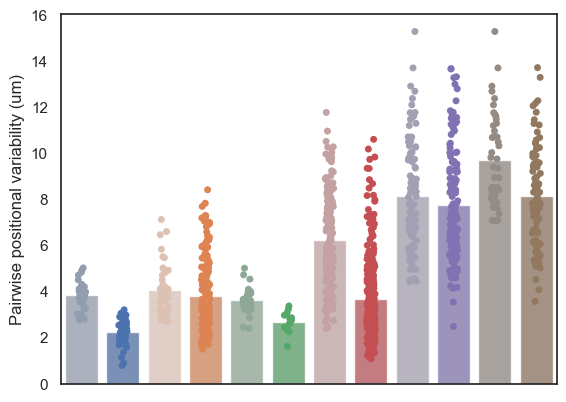

In [79]:
ganglia = get_ganglia_variance(atlas_df, pair_tot, 10)
plot_ganglion_variance(pair_tot, ganglia)

### Analysis of synaptic connectivity

In [94]:
def plot_synapses(pair_tot, synap_df):

    plt.rcParams.update({'font.size': 80})
    fig, axs = plt.subplots()
    sns.set(style='white')
    marker_size = 12

    df = pd.DataFrame(columns= ['Synaptic weight', 'LR pair', 'mean_dist', 'std_dist', 'Synapse type'])

    for i, row in synap_df.iterrows():
        source = row['Source']
        target = row['Target']
        weight = row['Weight']
        type = row['Type']

        if source == target:
            continue

        if source[:-1] == target[:-1]:
            LR = True
        else:
            LR = False

        if source < target:
            pair = source + '-' + target
        else: 
            pair = target + '-' + source

        if pair in pair_tot.keys():
            dists = pair_tot[pair]
            if len(dists) < 5:
                continue
            else:

                mean = np.mean(dists)
                std = np.std(dists)

                df.loc[len(df)] = [weight, LR, mean, std, type]

    sns.regplot(ax=axs, data=df[(df['LR pair']==False) & (df['Synapse type']=='chemical')],  x='mean_dist', y='Synaptic weight', marker='o', scatter_kws={'s':marker_size,  'color':'black'}, line_kws={'color':'red'})
    sns.scatterplot(ax=axs, data=df[(df['LR pair']==False) & (df['Synapse type']=='electrical')],  x='mean_dist', y='Synaptic weight', marker='^', color='gray')

    axs.legend(['Chemical', 'Chemical R²=0.25%', '_conf', 'Electrical', 'Electrical R²=0.01', '_conf2'])

    df_chem = df[(df['LR pair']==False) & (df['Synapse type']=='chemical')]
    df_elec = df[(df['LR pair']==False) & (df['Synapse type']=='electrical')]

    df_chem_under40 = df_chem[df_chem['mean_dist']<40]
    df_chem_over40 = df_chem[df_chem['mean_dist']>=40]

    coef_chem_spear, p_chem_spear = spearmanr(df_chem['mean_dist'], df_chem['Synaptic weight'])
    coef_elec_spear, p_elec_spear = spearmanr(df_elec['mean_dist'], df_elec['Synaptic weight'])

    coef_chem_kendall, p_chem_kendall = kendalltau(df_chem['mean_dist'], df_chem['Synaptic weight'])
    coef_elec_kendall, p_elec_kendall = kendalltau(df_elec['mean_dist'], df_elec['Synaptic weight'])

    coef_chem_pears, p_chem_pears = pearsonr(df_chem['mean_dist'], df_chem['Synaptic weight'])
    coef_elec_pears, p_elec_pears = pearsonr(df_elec['mean_dist'], df_elec['Synaptic weight'])

    coef_chem_spear_under40, p_chem_spear_under40 = spearmanr(df_chem_under40['mean_dist'], df_chem_under40['Synaptic weight'])
    coef_chem_spear_over40, p_chem_spear_over40 = spearmanr(df_chem_over40['mean_dist'], df_chem_over40['Synaptic weight'])

    coef_chem_kendall_under40, p_chem_kendall_under40 = kendalltau(df_chem_under40['mean_dist'], df_chem_under40['Synaptic weight'])
    coef_chem_kendall_over40, p_chem_kendall_over40 = kendalltau(df_chem_over40['mean_dist'], df_chem_over40['Synaptic weight'])

    coef_chem_pears_under40, p_chem_pears_under40 = pearsonr(df_chem_under40['mean_dist'], df_chem_under40['Synaptic weight'])
    coef_chem_pears_over40, p_chem_pears_over40 = pearsonr(df_chem_over40['mean_dist'], df_chem_over40['Synaptic weight'])


    print('Chemical Spearmen p-val: %.3f' %p_chem_spear)
    print('Electrical Spearmen p val: %.3f' %p_elec_spear)
    print('Chemical Spearmen R^2: %.3f' % (coef_chem_spear**2))
    print('Electrical Spearmen R^2: %.3f' % (coef_elec_spear**2))

    print('Chemical Kendalltau p-val: %.3f' %p_chem_kendall)
    print('Electrical Kendalltau p val: %.3f' %p_elec_kendall)
    print('Chemical Kendalltau R^2: %.3f' % (coef_chem_kendall**2))
    print('Electrical Kendalltau R^2: %.3f' % (coef_elec_kendall**2))

    print('Chemical Pearson p-val: %.3f' %p_chem_pears)
    print('Electrical Pearson p val: %.3f' %p_elec_pears)
    print('Chemical Pearson R^2: %.3f' % (coef_chem_pears**2))
    print('Electrical Pearson R^2: %.3f' % (coef_elec_pears**2))

    print(len(df_chem))
    print(len(df_elec))

    print('Chemical Spearmen under 40 p-val: %.3f' %p_chem_spear_under40)
    print('Chemical Spearmen over 40 p val: %.3f' %p_chem_spear_over40)
    print('Chemical Spearmen under 40 R^2: %.3f' % (coef_chem_spear_under40**2))
    print('Chemical Spearmen over 40 R^2: %.3f' % (coef_chem_spear_over40**2))

    print('Chemical kendall under 40 p-val: %.3f' %p_chem_kendall_under40)
    print('Chemical kendall over 40 p val: %.3f' %p_chem_kendall_over40)
    print('Chemical kendall under 40 R^2: %.3f' % (coef_chem_kendall_under40**2))
    print('Chemical kendall over 40 R^2: %.3f' % (coef_chem_kendall_over40**2))

    print('Chemical pearson under 40 p-val: %.3f' %p_chem_pears_under40)
    print('Chemical pearson over 40 p val: %.3f' %p_chem_pears_over40)
    print('Chemical pearson under 40 R^2: %.3f' % (coef_chem_pears_under40**2))
    print('Chemical pearson over 40 R^2: %.3f' % (coef_chem_pears_over40**2))

    print(len(df_chem_under40))
    print(len(df_chem_over40))

    stats = scipy.stats.ttest_ind(df_chem_under40['Synaptic weight'], df_chem_over40['Synaptic weight'], equal_var=False)
    pval = stats.pvalue
    tval = stats.statistic
    deg_free = stats.df
    SEM = np.std(np.append(df_chem_over40['Synaptic weight'], df_chem_under40['Synaptic weight'])) / np.sqrt(len(df_chem_over40) + len(df_chem_under40))
    lower_effect = (np.mean(df_chem_over40['Synaptic weight']) - np.mean(df_chem_under40['Synaptic weight'])) - SEM
    upper_effect = (np.mean(df_chem_over40['Synaptic weight']) - np.mean(df_chem_under40['Synaptic weight'])) +SEM

    print('For chemical synapyses over and under 40 um' +': t-statistic - '+ str(tval) +', pvalue - ' + str(pval)+ ', df - '+str(deg_free))
    print('Lower effect: '+ str(lower_effect))
    print('Upper effect: '+ str(upper_effect))

    axs.set_xlabel('Mean nuclear distance (um)')   
    axs.set_ylabel('Synaptic weight between pair of neurons')

    plt.show()



In [95]:
synap_df = pd.read_csv('../data/synaptic_connecs.csv') # Synaptic connections from Cook et al. 2019

plot_synapses(pair_tot, synap_df)

Chemical Spearmen p-val: 0.021
Electrical Spearmen p val: 0.798
Chemical Spearmen R^2: 0.002
Electrical Spearmen R^2: 0.000
Chemical Kendalltau p-val: 0.021
Electrical Kendalltau p val: 0.795
Chemical Kendalltau R^2: 0.001
Electrical Kendalltau R^2: 0.000
Chemical Pearson p-val: 0.000
Electrical Pearson p val: 0.512
Chemical Pearson R^2: 0.010
Electrical Pearson R^2: 0.001
6.3846262761214966e-06
8.254035831603852e-05
2119
444
Chemical Spearmen under 40 p-val: 0.218
Chemical Spearmen over 40 p val: 0.899
Chemical Spearmen under 40 R^2: 0.001
Chemical Spearmen over 40 R^2: 0.000
Chemical kendall under 40 p-val: 0.213
Chemical kendall over 40 p val: 0.915
Chemical kendall under 40 R^2: 0.000
Chemical kendall over 40 R^2: 0.000
Chemical pearson under 40 p-val: 0.575
Chemical pearson over 40 p val: 0.563
Chemical pearson under 40 R^2: 0.000
Chemical pearson over 40 R^2: 0.001
1723
396
For chemical synapyses over and under 40 um: t-statistic - 8.120890598669078, pvalue - 1.2647646361494711e-

/var/folders/gk/6ffbr8g11tqbyqmft2vx0y5h0000gn/T/ipykernel_93732/2906213240.py:43: UserWarning: The label '_conf' of <matplotlib.collections.PolyCollection object at 0x2e93a6590> starts with '_'. It is thus excluded from the legend.
  axs.legend(['Chemical', 'Chemical R²=0.25%', '_conf', 'Electrical', 'Electrical R²=0.01', '_conf2'])


### Analysis of cell lineage

In [38]:
def find_last_shared_neuron(neuron1, neuron2, lin_df):
    # Find the last shared neuron in the lineage between two neurons

    linealName1 = lin_df.loc[lin_df['#cellName']==neuron1]['linealName'].iloc[0]
    linealName2 = lin_df.loc[lin_df['#cellName']==neuron2]['linealName'].iloc[0]
    
    if linealName1[0:2] == 'G1':
        linealName1 = 'ABprpaaaapa'+linealName1[2]

    elif linealName1[0] == 'W' and linealName2[0]!='W':
        linealName1 = 'ABprapaapa' + linealName1[1:]

    if linealName2[0:2] == 'G1':
        linealName1 = 'ABprpaaaapa'+linealName2[2]

    elif linealName2[0] == 'W' and linealName2[0]!='W':
        linealName2 = 'ABprapaapa' + linealName2[1:]

    min_len = min(len(linealName1), len(linealName2))

    # Iterate through the characters until a mismatch is found
    last_shared = ''
    last_shared_index=0
    for i in range(min_len):
        if linealName1[i] == linealName2[i]:
            last_shared += linealName1[i]
            last_shared_index=i
        else:
            break

    if linealName1==linealName2:
        last_shared_birth = max(np.asarray(lin_df.loc[lin_df['#cellName']!='P0']['birthTimeInMin']).astype('int')) #if same neuron, set birht time to max
    elif len(last_shared)==0 or last_shared=='AB': #AB is original embryo cell so will have birth time 0
        last_shared_birth=0
    elif last_shared =='W':
        last_shared_birth = lin_df.loc[lin_df['#cellName']==last_shared]['birthTimeInMin'].iloc[0]
    #elif last_shared =='G': 
    #    last_shared = 'ABp'
    #    last_shared_birth = lin_df.loc[lin_df['linealName']==last_shared]['birthTimeInMin'].iloc[0]
    #elif not (lin_df['linealName']==last_shared).any(): #For G1 and G2, cell name is referenced rather than lineal name of parent
    #    last_shared = lin_df.loc[lin_df['#cellName']==last_shared]
    #    last_shared_birth = lin_df.loc[lin_df['#cellName']==last_shared]['birthTimeInMin'].iloc[0]
    else:
        last_shared_birth = lin_df.loc[lin_df['linealName']==last_shared]['birthTimeInMin'].iloc[0]

    tree_distance = len(linealName1[last_shared_index+1:]) + len(linealName2[last_shared_index+1:])

    return last_shared, last_shared_birth, tree_distance


In [56]:
def get_lin_dist_df(pair_tot, lin_df, atlas):
    pairs = np.asarray([key for key in pair_tot.keys()])
    N = np.asarray([len(value) for key, value in pair_tot.items()])
    means = np.asarray([np.mean(value) for key, value in pair_tot.items()])
    stds = np.asarray([np.std(value) for key, value in pair_tot.items()])
    norm_stds = np.divide(stds, means, out=np.zeros_like(stds), where=means!=0)
    norm_stds

    last_shared_list = ['']*len(pairs)
    first_neurs = ['']*len(pairs)
    second_neurs = ['']*len(pairs)
    lineal_dists = np.zeros(len(pairs))
    birth_dists = np.zeros(len(pairs))
    tree_dists = np.zeros(len(pairs))

    for i, pair in enumerate(pairs):
        neuron1 = pair.split('-')[0]
        neuron2 = pair.split('-')[1]

        if neuron1[-1] =='?':
            neuron1 = neuron1[:-1]
        if neuron2[-1] == '?':
            neuron2 = neuron2[:-1]

        first_neurs[i] = neuron1
        second_neurs[i] = neuron2
        if not neuron1 in atlas.neurons or not neuron2 in atlas.neurons:
            continue
        last_shared, last_shared_birth, tree_distance = find_last_shared_neuron(neuron1, neuron2, lin_df)
        last_shared_list[i] = last_shared
        lineal_dists[i] = len(last_shared)
        birth_dists[i] = last_shared_birth
        tree_dists[i] = tree_distance

    lin_dist_vals = np.transpose(np.vstack((pairs, N, first_neurs, second_neurs, means, stds, norm_stds, last_shared_list, lineal_dists, birth_dists, tree_dists)))

    lin_dist_df = pd.DataFrame(lin_dist_vals, columns = ['Pair', 'N', 'neuron1', 'neuron2', 'Mean_dist', 'Std_dist', 'Norm_std', 'last_shared', 'lin_dist', 'birth_dists', 'tree_dists'])
    lin_dist_df[['Mean_dist','Std_dist','Norm_std', 'lin_dist', 'birth_dists', 'tree_dists']] = lin_dist_df[['Mean_dist','Std_dist','Norm_std', 'lin_dist', 'birth_dists', 'tree_dists']].astype('float')
    lin_dist_df['N'] = lin_dist_df['N'].astype('int')

    return lin_dist_df

In [96]:
def plot_cell_lineage(pair_tot, lin_dist_df):

    plt.rcParams.update({'font.size': 80})
    fig, axs = plt.subplots(2,1)
    sns.set(style='white')
    marker_size = 12

    lin_dist_df['SEM'] = lin_dist_df['Std_dist']/lin_dist_df['N']

    lin_dist_df = lin_dist_df[lin_dist_df['tree_dists']==2.0] #Only look at sister cells
    lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]

    sns.regplot(ax=axs[0], data=lin_dist_plot, y='birth_dists',x='Mean_dist', x_ci=None , ci=0, scatter_kws={'s':10, 'color':'black'}, line_kws={'color':'red'})
    sns.scatterplot(ax=axs[1], data=lin_dist_plot, y='birth_dists',x='SEM', s=20, color='black')

    coef_spear_mean, p_spear_mean = spearmanr(lin_dist_plot['Mean_dist'], lin_dist_plot['birth_dists'])
    coef_kendall_mean, p_kendall_mean = kendalltau(lin_dist_plot['Mean_dist'], lin_dist_plot['birth_dists'])
    coef_pears_mean, p_pears_mean = pearsonr(lin_dist_plot['Mean_dist'], lin_dist_plot['birth_dists'])

    coef_spear_SEM, p_spear_SEM = spearmanr(lin_dist_plot['SEM'], lin_dist_plot['birth_dists'])
    coef_kendall_SEM, p_kendall_SEM = kendalltau(lin_dist_plot['SEM'], lin_dist_plot['birth_dists'])
    coef_pears_SEM, p_pears_SEM = pearsonr(lin_dist_plot['SEM'], lin_dist_plot['birth_dists'])

    print('Spearmans p-val for mean: %.3f' % p_spear_mean)
    print('Spearmans correlation coefficient for mean: %.3f' % (coef_spear_mean**2))
    print('Kendall p-val for mean: %.3f' % p_kendall_mean)
    print('Kendall correlation coefficient for mean: %.3f' % (coef_kendall_mean**2))
    print('Pearson p-val for mean: %.3f' % p_pears_mean)
    print('Pearson correlation coefficient for mean: %.3f' % (coef_pears_mean**2))

    print(coef_kendall_SEM**2)

    print('Spearmans p-val for SEM: %.3f' % p_spear_SEM)
    print('Spearmans correlation coefficient for SEM: %.3f' % (coef_spear_SEM**2))
    print('Kendall p-val for SEM: %.3f' % p_kendall_SEM)
    print('Kendall correlation coefficient for SEM: %.3f' % (coef_kendall_SEM**2))
    print('Pearson p-val for SEM: %.3f' % p_pears_SEM)
    print('Pearson correlation coefficient for SEM: %.3f' % (coef_pears_SEM**2))

    axs[0].set_ylabel('Birth time of last shared parent (minutes)')
    axs[0].set_xlabel('Mean adulthood nuclear distance (um)')
    axs[0].spines[['right', 'top']].set_visible (False)
    
    R2 = (coef_spear_mean**2)*100
    axs[0].legend(['_points', 'R²=%.3f' % R2 +'%'])

    axs[1].set_xlabel('SEM adulthood nuclear distance')
    axs[1].set_ylabel('Birth time of last shared parent (minutes)')
    axs[1].spines[['right', 'top']].set_visible (False)

    plt.show()

In [97]:
%matplotlib qt

lin_df = pd.read_csv('../data/worm_lineage.csv') # Cell lineage from Sulston et al. 1982
# Change names of a few cells to match labels in atlas
lin_df.loc[lin_df['#cellName']=='hmc', '#cellName'] = 'HMC'
lin_df.loc[lin_df['#cellName']=='AMsoR', '#cellName'] = 'AMSOR'
lin_df.loc[lin_df['#cellName']=='AMsoL', '#cellName'] = 'AMSOL'

lin_dist_df = get_lin_dist_df(pair_tot, lin_df, atlas)

plot_cell_lineage(pair_tot, lin_dist_df)

Spearmans p-val for mean: 0.039
Spearmans correlation coefficient for mean: 0.048
Kendall p-val for mean: 0.052
Kendall correlation coefficient for mean: 0.021
Pearson p-val for mean: 0.129
Pearson correlation coefficient for mean: 0.026
0.00021015904536325882
Spearmans p-val for SEM: 0.669
Spearmans correlation coefficient for SEM: 0.002
Kendall p-val for SEM: 0.845
Kendall correlation coefficient for SEM: 0.000
Pearson p-val for SEM: 0.487
Pearson correlation coefficient for SEM: 0.006


/var/folders/gk/6ffbr8g11tqbyqmft2vx0y5h0000gn/T/ipykernel_93732/2702385179.py:45: UserWarning: The label '_points' of <matplotlib.collections.PathCollection object at 0x286668a10> starts with '_'. It is thus excluded from the legend.
  axs[0].legend(['_points', 'R²=%.3f' % R2 +'%'])
